# EDA - Transit Cost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from config import CONFIG

### Data Dictionary

# `transit_cost.csv`

|variable         |class     |description |
|:----------------|:---------|:-----------|
|e                |double    | ID |
|country          |character | Country Code - can be joined against `countrycode` via `ecb` or `iso2c` |
|city             |character | City where transit tunnel is being created |
|line             |character | Line name or path |
|start_year       |character | Year started |
|end_year         |character | Year ended (predicted or actual) |
|rr               |double    | I think this is Railroad (0 or 1), where 1 == Railroad? |
|length           |double    | Length of proposed line in km |
|tunnel_per       |character | Percent of line length completed |
|tunnel           |double    | Tunnel length of line completed in km (can take this divided by length to get `tunnel_per`) |
|stations         |double    | Number of stations where passengers can board/leave |
|source1          |character | Where was data sourced |
|cost             |double    | Cost in millions of local currency |
|currency         |character | Currency type |
|year             |double    | Midpoint year of construction |
|ppp_rate         |double    | purchasing power parity (PPP), based on the midpoint of construction |
|real_cost        |character | Real cost in Millions of USD |
|cost_km_millions |double    | Cost/km in millions of USD |
|source2          |character | Where was data sourced for cost |
|reference        |character | Reference URL for source |

In [78]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-05/transit_cost.csv"

df = pd.read_csv(url)
df.head()


,e,country,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,source1,cost,currency,year,ppp_rate,real_cost,cost_km_millions,source2,reference
0,7136.0,CA,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,Plan,2830.0,CAD,2018.0,0.84,2377.2,417.052632,Media,https://www.translink.ca/Plans-and-Projects/Ra...
1,7137.0,CA,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,Media,3200.0,CAD,2013.0,0.81,2592,301.395349,Media,https://www.thestar.com/news/gta/transportatio...
2,7138.0,CA,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,Wiki,5500.0,CAD,2018.0,0.84,4620,592.307692,Media,https://urbantoronto.ca/news/2020/03/metrolinx...
3,7139.0,CA,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,Plan,8573.0,CAD,2019.0,0.84,7201.32,464.601290,Plan,https://metrolinx.files.wordpress.com/2019/07/...
4,7144.0,CA,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,Plan,5600.0,CAD,2020.0,0.84,4704,635.675676,Media,https://www.thestar.com/news/gta/2020/06/24/me...


In [79]:
df.shape

(544, 20)

From the first glance, we don't need <span style="color:red">*source1, source2 and reference*</span> as they are not important to our data analysis. We'll drop these variables. *year* variable is not clear. We'll also drop it. We'll analyze these projects in us currency so <span style="color:red">*cost* and *currentcy*</span> we'll be eliminated. If we know which city the project was built in, we'll know that country too. Hence, we'll drop <span style="color:red">*country*</span> from our table. 

In [80]:
vars_to_drop = ["source1", "source2", "reference", "year", "cost", "country", "currency"]
df1 = df.loc[:,[x for x in df.columns if x not in vars_to_drop]]
df1.head()

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
0,7136.0,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,0.84,2377.2,417.052632
1,7137.0,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,0.81,2592,301.395349
2,7138.0,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,0.84,4620,592.307692
3,7139.0,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,0.84,7201.32,464.601290
4,7144.0,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,0.84,4704,635.675676


In [81]:
df1.tail(10)

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
534,9510.0,Istanbul,M11 Phase 2,2019,2022,0.0,32.000000,100.00%,32.0000,7.0,3.7,3389.2,105.910000
535,9459.0,Tashkent,Sergeli Line,2017,2020,0.0,7.100000,0.00%,7.1000,6.0,5.0,711,100.140845
536,9460.0,Tashkent,Yunusabad Line extension,2017,2020,0.0,2.900000,100.00%,2.9000,2.0,5.0,624,215.172414
537,NaN,NaN,NaN,NaN,NaN,NaN,12256.983000,NaN,7790.7826,NaN,NaN,AVG,233.079919
538,NaN,NaN,NaN,NaN,NaN,NaN,7660.614375,NaN,NaN,NaN,NaN,MEDIAN,180.702862
539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STD,258.744889
540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIN,7.789626
541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 1,134.863267
542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUARTILE 3,241.428571
543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,567.000000


In [82]:
df2 = df1.iloc[:-7,:]
df2.tail()

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
532,9508.0,Istanbul,M12,2017,2022,0.0,13.0,100.00%,13.0,9.0,3.7,3411.4,262.420000
533,9509.0,Istanbul,M11 Phase 1,2016,2021,0.0,37.5,100.00%,37.5,9.0,3.1,3503,93.410000
534,9510.0,Istanbul,M11 Phase 2,2019,2022,0.0,32.0,100.00%,32.0,7.0,3.7,3389.2,105.910000
535,9459.0,Tashkent,Sergeli Line,2017,2020,0.0,7.1,0.00%,7.1,6.0,5.0,711,100.140845
536,9460.0,Tashkent,Yunusabad Line extension,2017,2020,0.0,2.9,100.00%,2.9,2.0,5.0,624,215.172414


### Handling Missing Values


In [83]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   e                 537 non-null    float64
 1   city              537 non-null    object 
 2   line              537 non-null    object 
 3   start_year        491 non-null    object 
 4   end_year          473 non-null    object 
 5   rr                536 non-null    float64
 6   length            537 non-null    float64
 7   tunnel_per        512 non-null    object 
 8   tunnel            511 non-null    float64
 9   stations          529 non-null    float64
 10  ppp_rate          535 non-null    float64
 11  real_cost         537 non-null    object 
 12  cost_km_millions  535 non-null    float64
dtypes: float64(7), object(6)
memory usage: 54.7+ KB


In [84]:
df2.loc[df2.start_year.isnull(),:]

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
119,7376.0,Tehran,Line 6,NaN,2020,0.0,31.000,100.00%,31.000,29.0,0.000064,5760,185.806452
120,7377.0,Tehran,Line 7,NaN,2019,0.0,27.000,100.00%,27.000,25.0,0.000064,5760,213.333333
204,7545.0,Nagpur,Phase 2,NaN,NaN,0.0,43.800,0.00%,0.000,32.0,0.048000,5383.68,122.915069
271,7712.0,Shenzhen,Line 3 Phase 4,NaN,2022,0.0,9.350,79.36%,7.420,7.0,0.238200,2568.99,274.760000
277,7722.0,Shenzhen,Line 8 Phase 3,NaN,2025,0.0,4.260,100.00%,4.260,NaN,0.238200,1981.35,465.110000
292,7754.0,Shanghai,Line 1 Western Extension,NaN,NaN,0.0,1.200,0.00%,0.000,1.0,0.237900,850.38,708.650000
293,7755.0,Shanghai,Line 20 Phase 1,NaN,NaN,0.0,19.800,100.00%,19.800,16.0,0.237900,9361.08,472.780000
295,7761.0,Wuhan,Line 11 Phase 3,NaN,NaN,0.0,9.900,100.00%,9.900,6.0,0.238200,3219.39,325.190000
296,7762.0,Shanghai,Line 19,NaN,NaN,0.0,44.500,100.00%,44.500,32.0,0.237900,14396.76,323.520000
297,7763.0,Shanghai,Line 21 Phase 1,NaN,NaN,0.0,28.000,100.00%,28.000,16.0,0.237900,8790.68,313.950000


In [87]:
df2.loc[df2.end_year.isnull(),:]

,e,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
21,7177.0,Sofia,Line 3 extension (Third Stage),2021,NaN,0.0,3.100,100.00%,3.1,4.0,3.320000,373.5,120.483871
153,7442.0,Hamburg,U4 to Dannerallee,2020,NaN,0.0,2.600,100.00%,2.6,3.0,1.300000,664.3,255.500000
174,7483.0,Bangkok,Brown Line,2020,NaN,0.0,22.100,0.00%,0.0,18.0,0.081000,3919.266,177.342353
204,7545.0,Nagpur,Phase 2,NaN,NaN,0.0,43.800,0.00%,0.0,32.0,0.048000,5383.68,122.915069
207,7552.0,Hyderabad,Airport express,2020,NaN,0.0,31.000,8.00%,2.5,10.0,0.047000,2185.5,70.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,8138.0,Changchun,Line 3 Southern Extension,NaN,NaN,0.0,3.000,26.67%,0.8,2.0,0.237900,199.57,66.520000
484,8147.0,Wenzhou,S2 Phase 1,NaN,NaN,0.0,70.299,NaN,NaN,NaN,0.266000,6969.94,99.150000
501,8187.0,Mecca,Mecca Metro,2009,NaN,NaN,188.000,NaN,NaN,90.0,0.616143,38200.8626,203.196078
502,8192.0,Ad Dammam,Dammam Metro (a-Sharqiya),2014,NaN,0.0,50.000,0.00%,0.0,NaN,1.623000,25968,519.360000


Most of the missing start_year and end_year come from China. We'll remove these nan values from our data

In [89]:
df3 = df2.loc[~(df2.start_year.isnull()) & ~(df2.end_year.isnull()), :]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 536
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   e                 465 non-null    float64
 1   city              465 non-null    object 
 2   line              465 non-null    object 
 3   start_year        465 non-null    object 
 4   end_year          465 non-null    object 
 5   rr                465 non-null    float64
 6   length            465 non-null    float64
 7   tunnel_per        445 non-null    object 
 8   tunnel            444 non-null    float64
 9   stations          460 non-null    float64
 10  ppp_rate          463 non-null    float64
 11  real_cost         465 non-null    object 
 12  cost_km_millions  463 non-null    float64
dtypes: float64(7), object(6)
memory usage: 50.9+ KB


Since e is just the ID variable, we'll eliminate it

In [90]:
df4 = df3.drop("e", axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 536
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              465 non-null    object 
 1   line              465 non-null    object 
 2   start_year        465 non-null    object 
 3   end_year          465 non-null    object 
 4   rr                465 non-null    float64
 5   length            465 non-null    float64
 6   tunnel_per        445 non-null    object 
 7   tunnel            444 non-null    float64
 8   stations          460 non-null    float64
 9   ppp_rate          463 non-null    float64
 10  real_cost         465 non-null    object 
 11  cost_km_millions  463 non-null    float64
dtypes: float64(6), object(6)
memory usage: 47.2+ KB


In [91]:
df4.loc[df4.stations.isnull(),:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
190,Tokyo,Monorail to Tokyo Station,2015,2025,1.0,3.00,0.00%,0.00,NaN,0.0100,1095,365.000000
336,Nanchang,Line 3,2015,2020,0.0,26.80,100.00%,26.80,NaN,0.2889,6370.99,237.720000
503,Doha,Doha Metro,2013,2026,0.0,124.00,89.92%,111.50,NaN,2.5000,90000,725.806452
505,Bahrain,Phase 2,2020,X,1.0,72.70,0.00%,0.00,NaN,5.0000,7500,103.163686
521,Shanghai,Line 16,2010,2014,0.0,58.96,23.22%,13.69,NaN,0.3004,5455.264,92.520000


We'll impute this variable with the median as it is an integer variable.

In [93]:
df4.loc[df4.real_cost == "0",:]

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
512,Cairo,Line 3 Phase 2,2009,2014,0.0,7.2,100.00%,7.2,4.0,NaN,0,NaN
513,Cairo,Line 3 Phase 3,2017,2022,0.0,11.6,100.00%,11.6,12.0,NaN,0,NaN


We'll drop the nan values of ppp_rate and cost_km_millions as they are related and since the real cost is 0, these data will create noise in our dataset.

In [94]:
df4.drop([512, 513], axis=0, inplace=True)


In [95]:
df5 = df4.fillna({"stations":"median"})
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 536
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              463 non-null    object 
 1   line              463 non-null    object 
 2   start_year        463 non-null    object 
 3   end_year          463 non-null    object 
 4   rr                463 non-null    float64
 5   length            463 non-null    float64
 6   tunnel_per        443 non-null    object 
 7   tunnel            442 non-null    float64
 8   stations          463 non-null    object 
 9   ppp_rate          463 non-null    float64
 10  real_cost         463 non-null    object 
 11  cost_km_millions  463 non-null    float64
dtypes: float64(5), object(7)
memory usage: 47.0+ KB


I'll remove end_year value that are X

In [101]:
df6 = df5.loc[df5.end_year != "X",:]

In [102]:
df6.head()

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
0,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,0.84,2377.2,417.052632
1,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,0.81,2592,301.395349
2,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,0.84,4620,592.307692
3,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,0.84,7201.32,464.601290
4,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,0.84,4704,635.675676


We'll perform knn permute on tunnel and infer tunnel_per from tunnel later.

In [52]:
knn_impute = ["tunnel"]

In [111]:
df6["end_year"] = df6["end_year"].astype("int")
df6["start_year"] = df6["start_year"].astype("int")

<ipython-input-111-ed5fa8273ddf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6["end_year"] = df6["end_year"].astype("int")
<ipython-input-111-ed5fa8273ddf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6["start_year"] = df6["start_year"].astype("int")


In [112]:
df6.to_csv(str(CONFIG.data / "intermediate" / "cleaned_data_before_imputing.csv"), index=False)

In [113]:
df = pd.read_csv(CONFIG.data / "intermediate" / "cleaned_data_before_imputing.csv")
df.head()

,city,line,start_year,end_year,rr,length,tunnel_per,tunnel,stations,ppp_rate,real_cost,cost_km_millions
0,Vancouver,Broadway,2020,2025,0.0,5.7,87.72%,5.0,6.0,0.84,2377.20,417.052632
1,Toronto,Vaughan,2009,2017,0.0,8.6,100.00%,8.6,6.0,0.81,2592.00,301.395349
2,Toronto,Scarborough,2020,2030,0.0,7.8,100.00%,7.8,3.0,0.84,4620.00,592.307692
3,Toronto,Ontario,2020,2030,0.0,15.5,57.00%,8.8,15.0,0.84,7201.32,464.601290
4,Toronto,Yonge to Richmond Hill,2020,2030,0.0,7.4,100.00%,7.4,6.0,0.84,4704.00,635.675676


#### 1. Which city has most transit projects? and what is their average cost?

<AxesSubplot:ylabel='city'>

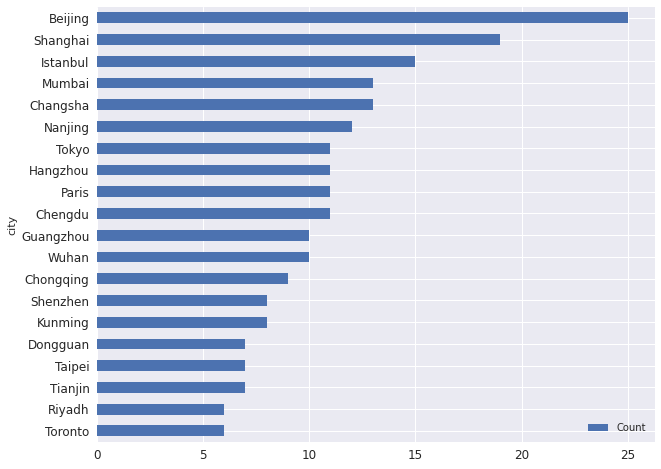

In [115]:
plt.rc("axes", labelsize=12)
plt.style.use("seaborn")
df.groupby("city").size().sort_values(ascending=True)[-20:].plot(kind="barh", figsize=(10,8), fontsize=12, label="Count", legend=True)


Beijing has the most number of projects with Shanghai trailing behind. Top 20 cities with most number of projects going are dominated by those from China.

<AxesSubplot:ylabel='city'>

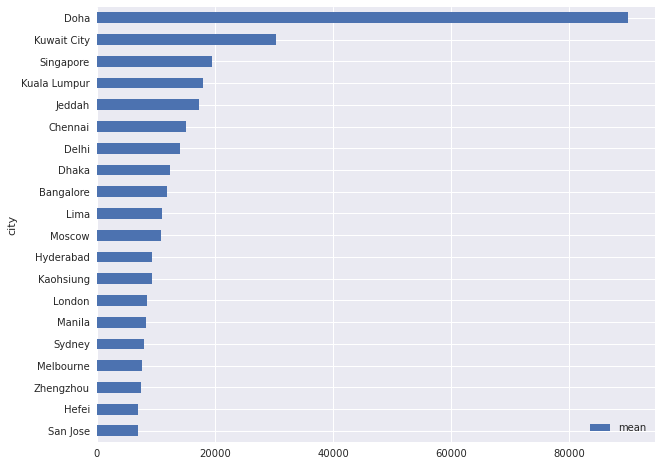

In [116]:
df.groupby("city")["real_cost"].agg(["mean"]).sort_values(by="mean", ascending=True)[-20:].plot(kind="barh", figsize=(10, 8))


The highest average cost for the projects, however, belongs to Doha. In fact, top 20 are dominated by middle eastern and western asia cities. 

#### 2. Railroad vs Non-Railroad Projects

<AxesSubplot:title={'center':'real_cost'}, xlabel='[rr]'>

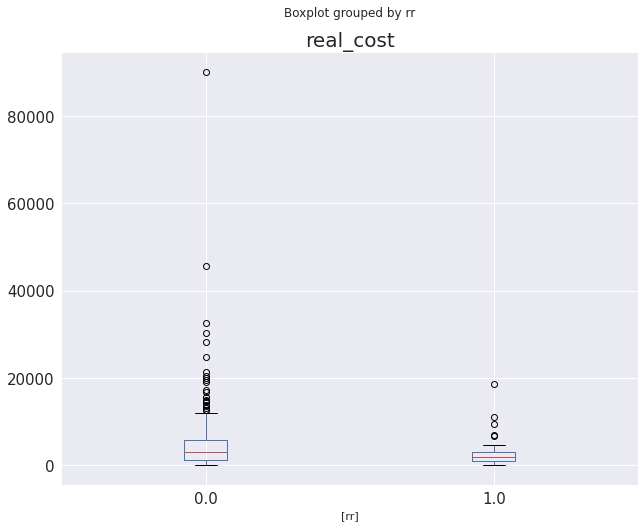

In [117]:
plt.rc("axes", titlesize=20)
df.boxplot(column=["real_cost"], by=["rr"], figsize=(10,8), fontsize=15)


It is clear that non_railroad projects cost more than railroad ones

#### 3. Which city has the highest cost per km?

In [118]:
df.loc[:20:,["city", "cost_km_millions"]].sort_values(by="cost_km_millions", ascending=False).groupby("city")["cost_km_millions"].agg("mean").sort_values(ascending=False)

city
San Jose         718.750000
Montreal         651.724138
San Francisco    618.518519
Los Angeles      609.866871
Toronto          498.495002
Vancouver        417.052632
Amsterdam        415.463917
Seattle          344.313725
Boston           301.184211
Ottawa           139.440000
Sofia            112.289213
Name: cost_km_millions, dtype: float64

It is not surprising that projects that cost the most per km are mostly in the U.S and Canada. 

#### 4. Does duration of the project affect the cost?

<AxesSubplot:ylabel='Frequency'>

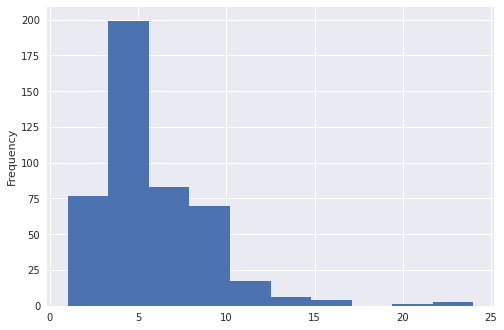

In [121]:
df["duration"] = df.end_year - df.start_year
df["duration"].plot(kind="hist")

Most of the projects last from 4-6 years. Some are about 20-25 years. Let's check if these projects cost more than the rest

In [127]:
print(f' The mean cost of projects last under 16 years and those that last more than 16 years, respectively: {df.loc[df.duration > 16, "real_cost"].mean():.3f}, {df.loc[df.duration < 16, "real_cost"].mean():.3f}')

 The mean cost of projects last under 16 years and those that last more than 16 years, respectively: 2832.033, 4396.698


It looks like duration of a project does not influence their cost. Let's investigate how long the top 25% of the cost last

In [133]:
real_cost_desc = df.real_cost.describe()
real_cost_desc


count      460.000000
mean      4376.289072
std       6223.118253
min         66.250000
25%       1170.487500
50%       2995.831500
75%       5635.907500
max      90000.000000
Name: real_cost, dtype: float64

The average, maximum and minimum length of the most expensive projects are: 6.148, 23.000, 1.000


<AxesSubplot:>

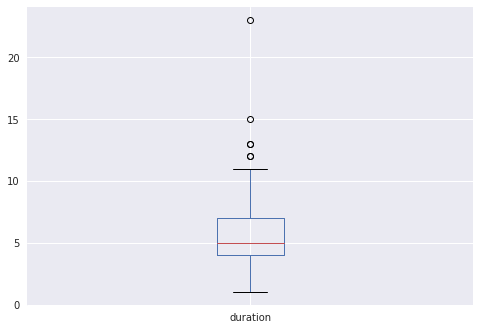

In [141]:
third_quantile = real_cost_desc[-2]
top25 = df.loc[df.real_cost > third_quantile, "duration"]
avg_length = top25.mean()
max_length = top25.max()
min_length = top25.min()
print(f"The average, maximum and minimum length of the most expensive projects are: {avg_length:.3f}, {max_length:.3f}, {min_length:.3f}")
top25.plot(kind="box")

Most of these projects actually last about 4-6 years.

### Conclusion
Our analysis shows that the cost of the projects are heavily influenced by where they are conducted. The most expensives ones, in terms of cost per km, are in the North America such one those in Los Angeles, Vancouver, etc. We can also see that the Middle Eastern projects also cost a lot on average as compared to those in China. My theory is that people in Middle Eastern prefer a grandiosh style project while those in China do not. Or it could be explained in terms of available capital (We all know that the ME countries are very rich!)